# Classifying Stability of Mantle with TensorFlow

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#When using Jupyter notebook make sure to call tf.reset_default_graph() 
# at the beginning to clear the symbolic graph before defining new nodes.
tf.reset_default_graph()

Gather Data

In [3]:
#Define a function to generate data set
def generate_data_set(instance_num = 10000, split_rate = 0.6):
    #instance[0]  Gravitational acceleration
    #instance[1]  Volumetric thermal expansion coefficient 
    #instance[2]  Kinematic viscosity coefficient 
    #instance[3]  Thermal diffusivity
    #instance[4]  Depth(10 km)
    #instance[5]  b
    #instance[6] λ
    #instance[7] (T0 - T1)/1000
    
    #label (1,0) for stable (0,1) for unstable
    
    #instance[8] stability 0 is unstable and 1 is stable
    counter_for_stable = 0
    counter_for_unstable = 0
    
    data_set = {'input':np.zeros([instance_num, 8]),'label':np.zeros([instance_num,2])}
    
    #simulate gravitational accelerations
    data_set['input'][:,0] = np.random.uniform(0.8,1.0,size=instance_num)
    
    #simulate Volumetric thermal expansion coefficient
    data_set['input'][:,1] = np.random.uniform(0.1,1.0,size=instance_num)
    
    #simulate Kinematic viscosity coefficient
    data_set['input'][:,2] = np.random.uniform(0.1,1.0,size=instance_num)
    
    #simulate Thermal diffusivity
    data_set['input'][:,3] = np.random.uniform(0.1,1.0,size=instance_num)
    
    #simulate Depth 10km
    data_set['input'][:,4] = np.random.uniform(0.10,0.30,size=instance_num)
    
    #simulate b 10km
    for idx in range(instance_num):
        data_set['input'][idx,5] = np.random.uniform(max([0.25,data_set['input'][idx,4]]),0.35)
        #simulate λ
        w_num = np.random.uniform(0.15,7.0,size=1)
        data_set['input'][idx,6] = np.pi*2*data_set['input'][idx,5]/w_num
    
    #simulate T0 - T1
    data_set['input'][:,7] = np.random.uniform(0.0,0.8,size=instance_num)
    
    for idx in range(instance_num):
        #
        g = data_set['input'][idx,0]*10
        a = data_set['input'][idx,1]*1e-5
        v = data_set['input'][idx,2]
        k = data_set['input'][idx,3]
        d = data_set['input'][idx,4]
        b = data_set['input'][idx,5]*10000
        lam = data_set['input'][idx,6]*10000
        dT = data_set['input'][idx,7]*1000
        
        Ra = ((a*g*dT*(d**3))/(v*k))*1e7
        
        Racr = ((np.pi**4)*((4+(lam/b)**2)**3))/(4*((lam/b)**4))
        
        if Ra > Racr:
            data_set['label'][idx,0] = 0
            data_set['label'][idx,1] = 1
            counter_for_unstable += 1
        else:
            data_set['label'][idx,0] = 1
            data_set['label'][idx,1] = 0
            counter_for_stable += 1
            
    split_index = int(instance_num*split_rate)
    
    train_set = {'input':data_set['input'][0:split_index,:],
                 'label':data_set['label'][0:split_index,:]}
    test_set = {'input':data_set['input'][split_index:,:],
                 'label':data_set['label'][split_index:,:]}
    
    print('Stable:{} UnStable:{}'.format(counter_for_stable, counter_for_unstable))
    
    return train_set,test_set

Generate Train Set and Test Set

In [4]:
data_set_size = 1000000
split_rate = 0.5
train_set, test_set = generate_data_set(instance_num = data_set_size, split_rate = split_rate)

Stable:285097 UnStable:714903


Define Fully Connected Layer

In [5]:
#define fully connected layer
def fully_connected_layer(input_tensor, n_out,
                          reuse = False,
                          w_init=tf.truncated_normal_initializer(stddev=0.1), 
                          b_init=tf.constant_initializer(0.1), 
                          activation=tf.nn.sigmoid, name=None):
    n_in = input_tensor.get_shape().as_list()[1]
    with tf.variable_scope(name,reuse=reuse):
        weight = tf.get_variable('weight',[n_in, n_out],initializer=w_init)
        bias = tf.get_variable('bias',[n_out],initializer=b_init)
    output_tensor = activation(tf.matmul(input_tensor,weight)+bias,name=name+'_output')
    return output_tensor

Define Inference

In [14]:
def inference(input_tensor, return_represent_layer = False, reuse = False):
    hidden_layer_1 = fully_connected_layer(input_tensor=input_tensor,n_out=2,reuse = reuse, name='fc_layer_1')
    #hidden_layer_2 = fully_connected_layer(input_tensor=hidden_layer_1,n_out=8,reuse = reuse, name='fc_layer_2')
    #hidden_layer_3 = fully_connected_layer(input_tensor=hidden_layer_2,n_out=4,reuse = reuse, name='fc_layer_3')
    #hidden_layer_4 = fully_connected_layer(input_tensor=hidden_layer_3,n_out=2,reuse = reuse, name='fc_layer_4')
    pred = fully_connected_layer(input_tensor=hidden_layer_1,n_out=2, reuse = reuse, name='pred')
    if return_represent_layer:
        return hidden_layer_1
    else:
        return pred

Setup Training

In [7]:
#set param for training
step_num = 20001
batch_size = 2000
data_length = 8
learning_rate = 0.01
#setup training 
input_tensor = tf.placeholder(tf.float32,[None,data_length], name='input')
label = tf.placeholder(tf.float32,[None,2], name='label')
pred = inference(input_tensor=input_tensor)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=label))
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

In [8]:
def get_traning_batch(train_set, batch_size, data_length):
    batch_ids = np.random.choice(len(train_set['input']),batch_size)
    input_batch = np.zeros([batch_size,data_length])
    label_batch = np.zeros([batch_size,2])
    for idx in range(batch_size):
        input_batch[idx][:] = train_set['input'][batch_ids[idx]][:]
        label_batch[idx][:] = train_set['label'][batch_ids[idx]][:]
    return input_batch,label_batch

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Training

In [10]:
#start training
for idx in range(step_num):
    input_batch, label_batch = get_traning_batch(train_set, batch_size, data_length)
    _, loss_val = sess.run([train_op, loss], {input_tensor: input_batch, label: label_batch})
    if idx%2000 == 0:
        print(loss_val)

0.69516236
0.42825872
0.4243717
0.42555964
0.4258565
0.42156556
0.42783427
0.4280132
0.4149778
0.4191918
0.41456756


Testing

In [11]:
correct_pred = tf.equal(tf.argmax(pred,1),tf.argmax(label,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
test_pred, test_accuracy = sess.run([pred, accuracy],{input_tensor: test_set['input'], label: test_set['label']})
print('Accuracy: {}'.format(test_accuracy))

Accuracy: 0.9052299857139587


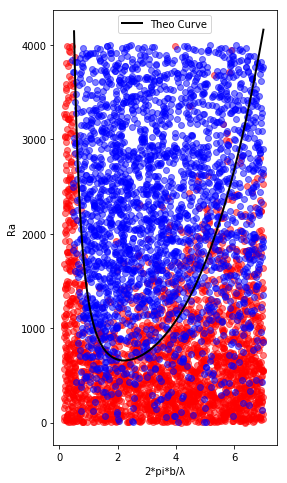

In [12]:
#compare test results with theoretical curve
plt.figure(figsize=(4,8))
x_pred_stable = []
y_pred_stable = []
x_pred_unstable = []
y_pred_unstable = []

for idx in range(min(len(test_set['input']),10000)):
    g = test_set['input'][idx,0]*10
    a = test_set['input'][idx,1]*1e-5
    v = test_set['input'][idx,2]
    k = test_set['input'][idx,3]
    d = test_set['input'][idx,4]
    b = test_set['input'][idx,5]*10000
    lam = test_set['input'][idx,6]*10000
    dT = test_set['input'][idx,7]*1000
    #map_x = ((np.pi**4)*((4+(lam/b)**2)**3))/(4*((lam/b)**4))
    map_x = (2.0*np.pi*b)/lam
    map_y = ((a*g*dT*(d**3))/(v*k))*1e7
    if map_y > 4000:
        continue
    
    if np.argmax(test_pred[idx])==0:
        map_color = 'r'
        x_pred_stable.append(map_x)
        y_pred_stable.append(map_y)
    else:
        map_color = 'b'
        x_pred_unstable.append(map_x)
        y_pred_unstable.append(map_y)
    #plt.plot([map_x],[map_y],color=map_color,marker='o')
#plot theo curve
plt.scatter(x_pred_stable,y_pred_stable,color='r',alpha=0.5)
plt.scatter(x_pred_unstable,y_pred_unstable,color='b',alpha=0.5)
plot_x = np.arange(0.5,7,0.001)
plot_y = ((np.pi**4)*((4+(2*np.pi/plot_x)**2)**3))/(4*((2*np.pi/plot_x)**4))
plt.plot(plot_x,plot_y,color='k',linewidth=2,label='Theo Curve')
plt.xlabel('2*pi*b/λ')
plt.ylabel('Ra')
plt.legend()
plt.show()

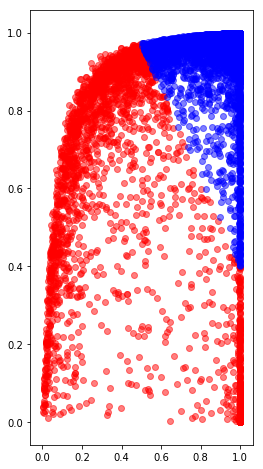

In [15]:
#visualize model
plt.figure(figsize=(4,8))
x_pred_stable = []
y_pred_stable = []
x_pred_unstable = []
y_pred_unstable = []

represent_layer = inference(input_tensor=input_tensor, return_represent_layer = True, reuse = True)

represent_out = sess.run(represent_layer,{input_tensor: test_set['input']})
for idx in range(min(len(test_set['input']),10000)):
    map_x = represent_out[idx,0]
    map_y = represent_out[idx,1]
    if np.argmax(test_pred[idx])==0:
        x_pred_stable.append(map_x)
        y_pred_stable.append(map_y)
    else:
        x_pred_unstable.append(map_x)
        y_pred_unstable.append(map_y)
plt.scatter(x_pred_stable,y_pred_stable,color='r',alpha=0.5)
plt.scatter(x_pred_unstable,y_pred_unstable,color='b',alpha=0.5)
plt.show()